<a href="https://colab.research.google.com/github/GwiHwan-Go/Reproduce_CutMix/blob/main/Code_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/GwiHwan-Go/Reproduce_CutMix/blob/main/Code_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
DIR = '/content/gdrive/MyDrive/DL'

Mounted at /content/gdrive


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data.dataloader import *
import os

#### 1-1. cifar-100 
##### Transfrom setting as CutMix Paper

In [3]:
batch_size = 32
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                  std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

train_set = torchvision.datasets.CIFAR100('../data', train=True, download=True, transform=transform_train)
cifar100_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = torchvision.datasets.CIFAR100('../data', train=False, download=True, transform=transform_test)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ../data/cifar-100-python.tar.gz to ../data
Files already downloaded and verified


#### 1-2. Tiny-Imagenet
##### Transform setting from one of kaggler

In [8]:
# After download dataset from http://cs231n.stanford.edu/tiny-imagenet-200.zip and upload to google drive

!cp "/content/gdrive/MyDrive/DL/Data/tiny-imagenet-200.zip" .
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200

test  train  val  wnids.txt  words.txt


In [20]:
batch_size = 32
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,

        ])
test_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            normalize,

        ])

def parseClasses(file):
    classes = []
    filenames = []
    with open(file) as f:
        lines = f.readlines()
    lines = [x.strip() for x in lines]
    for x in range(0,len(lines)):
        tokens = lines[x].split()
        classes.append(tokens[1])
        filenames.append(tokens[0])
    return filenames,classes
    
class TImgNetDataset(Dataset):
    """Dataset wrapping images and ground truths."""
    
    def __init__(self, img_path, gt_path, class_to_idx=None, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.gt_path = gt_path
        self.class_to_idx = class_to_idx
        self.classidx = []
        self.imgs, self.classnames = parseClasses(gt_path)
        for classname in self.classnames:
            self.classidx.append(self.class_to_idx[classname])

    def __getitem__(self, index):
            """
            Args:
                index (int): Index
            Returns:
                tuple: (image, y) where y is the label of the image.
            """
            img = None
            with open(os.path.join(self.img_path, self.imgs[index]), 'rb') as f: #Read Image
                img = Image.open(f)
                img = img.convert('RGB')
                if self.transform is not None:
                    img = self.transform(img)
            y = self.classidx[index]
            return img, y

    def __len__(self):
        return len(self.imgs)

train_set = datasets.ImageFolder("./tiny-imagenet-200/train", transform=train_transform)
tImage_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

val_set = TImgNetDataset("./tiny-imagenet-200/val/images", "./tiny-imagenet-200/val/val_annotations.txt", class_to_idx=tImage_train_loader.dataset.class_to_idx.copy(),
            transform=test_transform)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = datasets.ImageFolder("./tiny-imagenet-200/test", transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

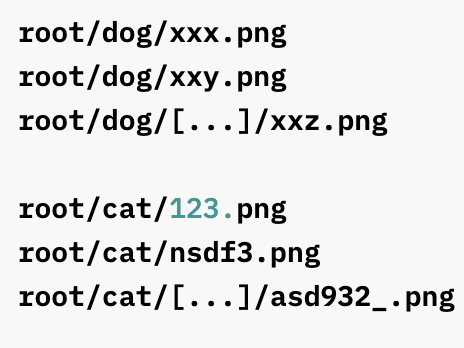

## 2. Introduce Algorithm
----------------------------
##### 2-1. Cutout
##### 2-2. Mixup
#### 2-3. *CutMix*
##### 2-4. Compare

In [14]:
import numpy as np

def cut(W,H,lam):
        
    cut_rat = np.sqrt(1. - lam) # define the size of box to cut

    cut_w = np.int64(W * cut_rat) # define the width of box to cut
    cut_h = np.int64(H * cut_rat) 

    
    cx = np.random.randint(W) # uniform distribution
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W) # Cut, return coordinates of the box 
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [15]:
images, labels = next(iter(valid_loader))

rand_index = torch.randperm(images.shape[0]) #Make random indices in a batch to mix between a batch
shuffled_images = images[rand_index]

lam = np.random.beta(1.0, 1.0) # Beta distributtion

cutmix_images = images.clone().detach() # copy Images
cutout_images = images.clone().detach() 
mixup_images = images.clone().detach() 

bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix


In [16]:
## CUTMIX ##
cutmix_images[:, :, bbx1:bbx2, bby1:bby2] = cutmix_images[rand_index, :, bbx1:bbx2, bby1:bby2]

##* CUTOUT *##
cutout_images[:, :, bbx1:bbx2, bby1:bby2] = 0.

## MIXUP ##
mixup_images = lam * mixup_images + (1 - lam) * mixup_images[rand_index,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


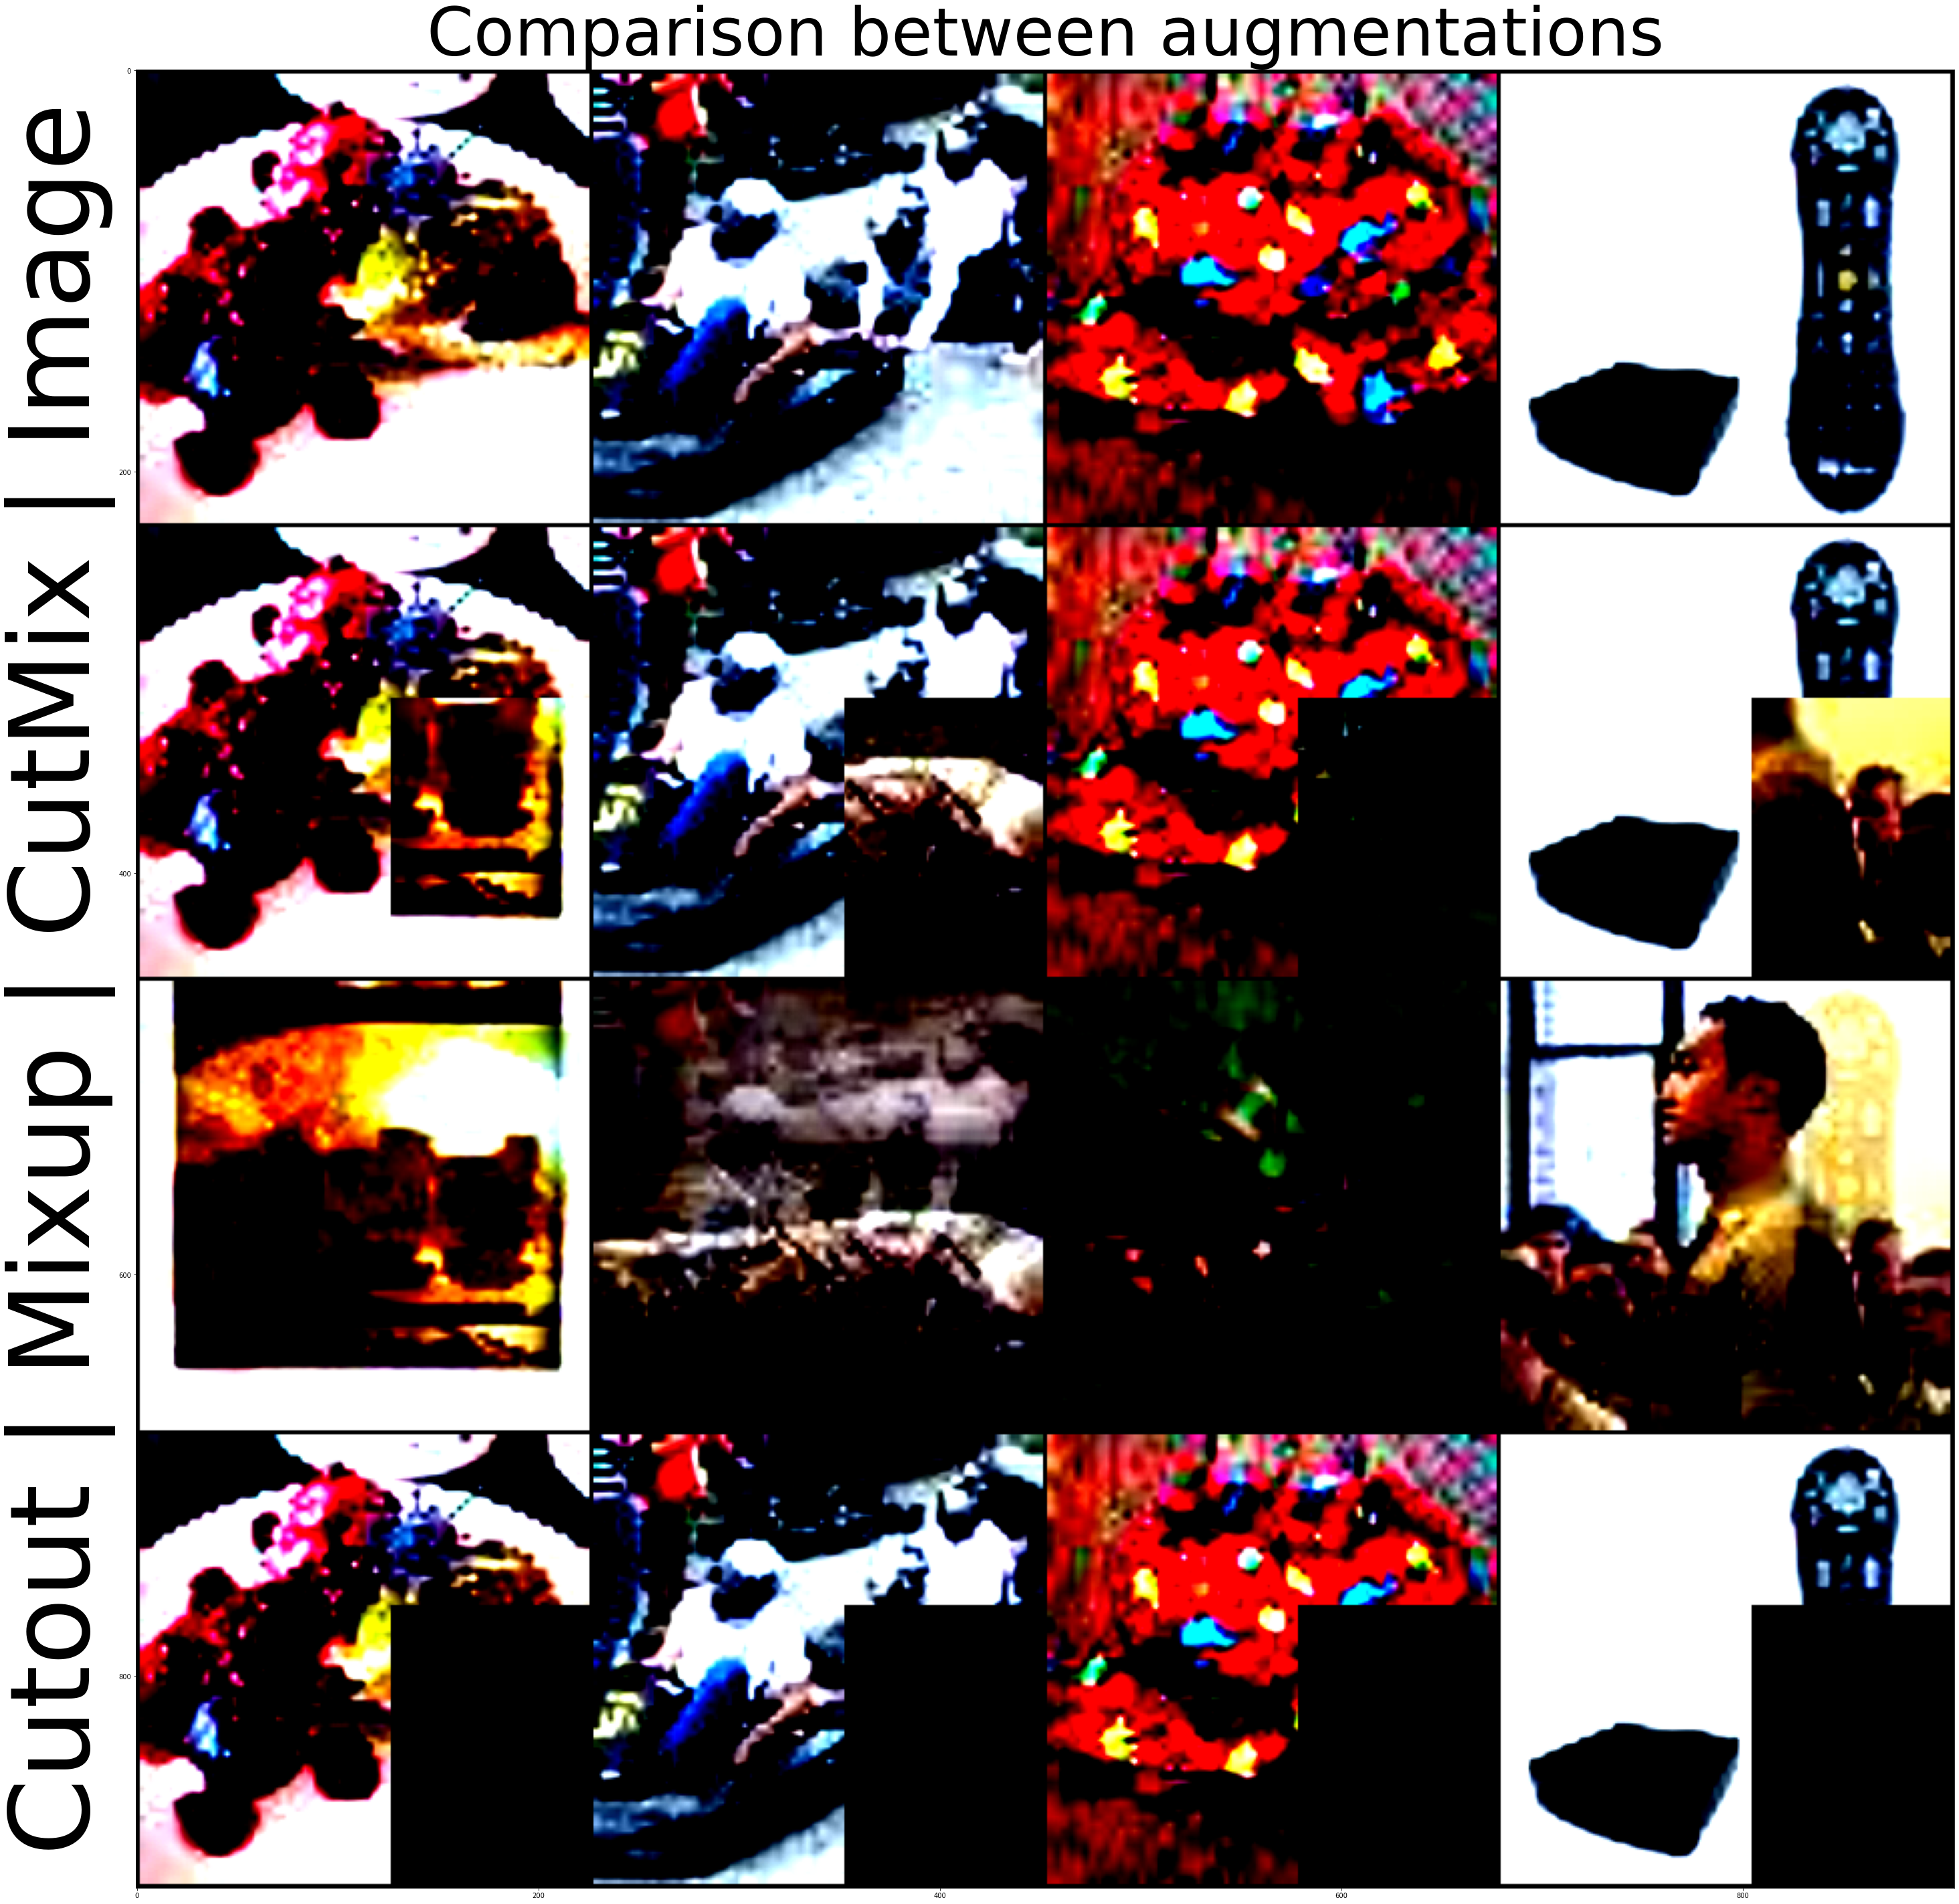

In [17]:
  
def show_cutMixed_compare(row1, row2, row3, row4, nums_show): # Let's compare each Algorithm in visual.

    rand_index = torch.randperm(row1.size()[0])[:nums_show]
    to_compare = torch.cat([row1[rand_index,:,:],row2[rand_index,:,:],row3[rand_index,:,:],row4[rand_index,:,:]],dim=0)
    plt.figure(figsize=(50,50))
    grid = torchvision.utils.make_grid(tensor=to_compare, nrow=nums_show)
    plt.ylabel("Cutout | Mixup | CutMix | Image",fontsize=165, rotation = 90)
    plt.title("Comparison between augmentations", fontsize=100)
    plt.imshow(grid.permute(1,2,0))

show_cutMixed_compare(images, cutmix_images, mixup_images, cutout_images, 4)

## 3. Introduce Models
----------------------------
##### 3-1. ResNet-50
##### 3-2. PyramidNet-110 & 200

In [18]:
from torch.nn import Linear
from torchvision import models

# resnet Model Loading
model = models.resnet18(pretrained=False) 

## Tunning the final output as our number of labels.
model.fc = torch.nn.Linear(512, 200) ## if resnet50 : 2048,200
print('the number of model parameters: {}'.format(sum([p.data.nelement() for p in model.parameters()])))

the number of model parameters: 11279112


In [19]:
import math

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    outchannel_ratio = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv3x3(inplanes, planes, stride)        
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn3 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        out = self.bn1(x)
        out = self.conv1(out)        
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        if self.downsample is not None:
            shortcut = self.downsample(x)
            featuremap_size = shortcut.size()[2:4]
        else:
            shortcut = x
            featuremap_size = out.size()[2:4]

        batch_size = out.size()[0]
        residual_channel = out.size()[1]
        shortcut_channel = shortcut.size()[1]

        if residual_channel != shortcut_channel:
            padding = torch.autograd.Variable(torch.cuda.FloatTensor(batch_size, residual_channel - shortcut_channel, featuremap_size[0], featuremap_size[1]).fill_(0)) 
            out += torch.cat((shortcut, padding), 1)
        else:
            out += shortcut 

        return out


class Bottleneck(nn.Module):
    outchannel_ratio = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, reduction=16):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, (planes), kernel_size=3, stride=stride, padding=1, bias=False, groups=1)
        self.bn3 = nn.BatchNorm2d((planes))
        self.conv3 = nn.Conv2d((planes), planes * Bottleneck.outchannel_ratio, kernel_size=1, bias=False)
        self.bn4 = nn.BatchNorm2d(planes * Bottleneck.outchannel_ratio)
        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        out = self.bn1(x)
        out = self.conv1(out)
        
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
 
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        out = self.bn4(out)
        if self.downsample is not None:
            shortcut = self.downsample(x)
            featuremap_size = shortcut.size()[2:4]
        else:
            shortcut = x
            featuremap_size = out.size()[2:4]

        batch_size = out.size()[0]
        residual_channel = out.size()[1]
        shortcut_channel = shortcut.size()[1]

        if residual_channel != shortcut_channel:
            padding = torch.autograd.Variable(torch.cuda.FloatTensor(batch_size, residual_channel - shortcut_channel, featuremap_size[0], featuremap_size[1]).fill_(0)) 
            out += torch.cat((shortcut, padding), 1)
        else:
            out += shortcut 

        return out


class PyramidNet(nn.Module):
        
    def __init__(self, dataset, depth, alpha, num_classes, bottleneck=False):
        super(PyramidNet, self).__init__()   	
        self.dataset = dataset
        if self.dataset.startswith('cifar'):
            self.inplanes = 16
            if bottleneck == True:
                n = int((depth - 2) / 9)
                block = Bottleneck
            else:
                n = int((depth - 2) / 6)
                block = BasicBlock

            self.addrate = alpha / (3*n*1.0)

            self.input_featuremap_dim = self.inplanes
            self.conv1 = nn.Conv2d(3, self.input_featuremap_dim, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(self.input_featuremap_dim)

            self.featuremap_dim = self.input_featuremap_dim 
            self.layer1 = self.pyramidal_make_layer(block, n)
            self.layer2 = self.pyramidal_make_layer(block, n, stride=2)
            self.layer3 = self.pyramidal_make_layer(block, n, stride=2)

            self.final_featuremap_dim = self.input_featuremap_dim
            self.bn_final= nn.BatchNorm2d(self.final_featuremap_dim)
            self.relu_final = nn.ReLU(inplace=True)
            self.avgpool = nn.AvgPool2d(8)
            self.fc = nn.Linear(self.final_featuremap_dim, num_classes)

        elif dataset == 'imagenet':
            blocks ={18: BasicBlock, 34: BasicBlock, 50: Bottleneck, 101: Bottleneck, 152: Bottleneck, 200: Bottleneck}
            layers ={18: [2, 2, 2, 2], 34: [3, 4, 6, 3], 50: [3, 4, 6, 3], 101: [3, 4, 23, 3], 152: [3, 8, 36, 3], 200: [3, 24, 36, 3]}

            if layers.get(depth) is None:
                if bottleneck == True:
                    blocks[depth] = Bottleneck
                    temp_cfg = int((depth-2)/12)
                else:
                    blocks[depth] = BasicBlock
                    temp_cfg = int((depth-2)/8)

                layers[depth]= [temp_cfg, temp_cfg, temp_cfg, temp_cfg]
                print('=> the layer configuration for each stage is set to', layers[depth])

            self.inplanes = 64            
            self.addrate = alpha / (sum(layers[depth])*1.0)

            self.input_featuremap_dim = self.inplanes
            self.conv1 = nn.Conv2d(3, self.input_featuremap_dim, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(self.input_featuremap_dim)
            self.relu = nn.ReLU(inplace=True)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

            self.featuremap_dim = self.input_featuremap_dim 
            self.layer1 = self.pyramidal_make_layer(blocks[depth], layers[depth][0])
            self.layer2 = self.pyramidal_make_layer(blocks[depth], layers[depth][1], stride=2)
            self.layer3 = self.pyramidal_make_layer(blocks[depth], layers[depth][2], stride=2)
            self.layer4 = self.pyramidal_make_layer(blocks[depth], layers[depth][3], stride=2)

            self.final_featuremap_dim = self.input_featuremap_dim
            self.bn_final= nn.BatchNorm2d(self.final_featuremap_dim)
            self.relu_final = nn.ReLU(inplace=True)
            self.avgpool = nn.AvgPool2d(7) 
            self.fc = nn.Linear(self.final_featuremap_dim, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def pyramidal_make_layer(self, block, block_depth, stride=1):
        downsample = None
        if stride != 1: # or self.inplanes != int(round(featuremap_dim_1st)) * block.outchannel_ratio:
            downsample = nn.AvgPool2d((2,2), stride = (2, 2), ceil_mode=True)

        layers = []
        self.featuremap_dim = self.featuremap_dim + self.addrate
        layers.append(block(self.input_featuremap_dim, int(round(self.featuremap_dim)), stride, downsample))
        for i in range(1, block_depth):
            temp_featuremap_dim = self.featuremap_dim + self.addrate
            layers.append(block(int(round(self.featuremap_dim)) * block.outchannel_ratio, int(round(temp_featuremap_dim)), 1))
            self.featuremap_dim  = temp_featuremap_dim
        self.input_featuremap_dim = int(round(self.featuremap_dim)) * block.outchannel_ratio

        return nn.Sequential(*layers)

    def forward(self, x):
        if self.dataset == 'cifar10' or self.dataset == 'cifar100':
            x = self.conv1(x)
            x = self.bn1(x)
            
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = self.bn_final(x)
            x = self.relu_final(x)
            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)

        elif self.dataset == 'imagenet':
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.maxpool(x)

            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)

            x = self.bn_final(x)
            x = self.relu_final(x)
            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
    
        return x
####################################################

dataset='cifar100'
depth=110
alpha=64
NUM_CLASSES=100
use_bottleneck=False

model = PyramidNet(dataset, depth, alpha, NUM_CLASSES,
                        use_bottleneck)
print('the number of model parameters: {}'.format(sum([p.data.nelement() for p in model.parameters()])))


the number of model parameters: 2623666


## 4. Introduce Training Process
##### 4-1. Loss functions per every methods
##### 4-2. Savepoint
##### 4-3. Hyper-Params

In [22]:
import torch.optim as optim
import torch.nn as nn
from tqdm.auto import tqdm, trange

    
def accuracy(output, target, topk=(1,)): ## Calculate top-1-errors and top-5-errors
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        wrong_k = batch_size - correct_k
        res.append(wrong_k.mul_(100.0 / batch_size))
    return res
    
def train_model(model, 
                train, 
                valid,
                resume = None,
                n_iters=300, 
                learn_rate=0.1, 
                weight_decay=0, 
                which_method=0
                ):  # Lists to store model's performance information
  po = 0
  DIR = '/content/gdrive/MyDrive/DL/checkpoints'
  top1_errs, top5_errs, train_losses = [], [], []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print(f"we are going to use {device}")
###############Checkpoint Zone################
  if resume is not None :
    checkpoint = torch.load(resume) 
    model.load_state_dict(checkpoint['model_state_dict'])
    loss = checkpoint['loss']
    num_epochs = checkpoint['total_epochs'] - checkpoint['epoch']
    top1_errs = checkpoint['top1_err']
    top5_errs = checkpoint['top5_err']
  else :
    num_epochs = n_iters
###############Checkpoint Zone###############
  
  print(f"We still have to go {num_epochs} epochs" )
  for i in trange(num_epochs):

    ##############################learning_decay#####################################
    if (num_epochs-i) < 75 :
      newpo = 3
    elif (num_epochs-i) < 150 :
      newpo = 2
    elif (num_epochs-i) < 225 :
      newpo = 1
    else :
      newpo = 0
    if po != newpo :
      po = newpo
      lr = learn_rate * (0.1 ** po) ##learning_decay
      print(f"lr has decayed to {lr}")
      optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    ##############################learning_decay#####################################

    try :
      for images, labels in tqdm(train) :

        images, labels = images.to(device), labels.to(device)
        model = model.to(device)
        model.train() # For Dropout and Batch Norm layers #

        if which_method and (np.random.rand()<0.5) :

          lam = np.random.beta(1.0, 1.0)
          rand_index = torch.randperm(images.size()[0])
          shuffled_labels = labels[rand_index]

          ##############Do Something On Data###############
          if which_method == 1 : ##cutmix
            bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.shape[-1] * images.shape[-2])) # the size of box changed
          if which_method == 2 : ##mixup
            images = lam * images + (1 - lam) * images[rand_index,:,:]
          if which_method == 3 : ##cutout
            bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut
            images[:, :, bbx1:bbx2, bby1:bby2] = 0.
          ##############Do Something On Data###############

          #############Forward Pass##############
          out = model(images) 
          #############Forward Pass##############

          ##############Modify Loss Function###############
          if which_method == 1 : ##cutmix ----> calculate the loss as much as it used
            loss = criterion(out, labels) * lam + criterion(out, shuffled_labels)*(1.0-lam) # compute the total loss
          if which_method == 2 : ##mixup ----> calculate the loss as much as it used
            loss = criterion(out, labels) * lam + criterion(out, shuffled_labels)*(1.0-lam)
          if which_method == 3 : ##cutout
            loss = criterion(out, labels)
          ##############Modify Loss Function###############

        else : ## if random.rand > 0.5 or which_method == 0
          
          out = model(images)
          loss = criterion(out, labels)

        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # reset the gradients for the next iteration
      
      #####################model Evaluation#############
      sum_top1, sum_top5 = 0,0
      
                
      with torch.no_grad():
        model.eval()
        for images, labels in valid :

          images,labels = images.to(device), labels.to(device)
          output = model(images)
          
          top1, top5 = accuracy(output, labels, topk=(1,5))
          sum_top1+=top1.item()
          sum_top5+=top5.item()
      
      size = len(valid)
      #####################model Evaluation#############

      ###################save history#####################
      train_losses.append(loss.item())
      top1_errs.append(sum_top1/size)
      top5_errs.append(sum_top5/size)
      ###################save history#####################

      n_step = 3
      if (i+1) % n_step == 0 : #save the checkpoint every n_step

        PATH=f"{300-(num_epochs-i)}th_checkpoint.pt"
        torch.save({'total_epochs':num_epochs, 'epoch': i, 'model_state_dict': model.state_dict(), 
        'optimizer_state_dict': optimizer.state_dict(), 'loss': loss, 'top1_err': top1_errs, 'top5_err': top5_errs, 'train_loss':train_losses }, DIR+'/'+PATH)
        print(f"Successfully saved untill {i} step in {DIR}/{PATH} with model, optimizer, and loss.")

    except :
      PATH=f"{300-(num_epochs-i)}th_checkpoint.pt"
      torch.save({'total_epochs':num_epochs, 'epoch': i, 'model_state_dict': model.state_dict(), 
      'optimizer_state_dict': optimizer.state_dict(), 'loss': loss, 'top1_err': top1_errs, 'top5_err': top5_errs , 'train_loss':train_losses},  DIR+'/'+PATH)
      print(f"Successfully saved untill {i} step in {DIR}/{PATH} with model, optimizer, and loss.")
      return [top1_errs,top5_errs]

  PATH = "trained.pt"
  print("train finished")
  print(f"Successfully saved untill {n_iters} step in {DIR}/{PATH} with model, optimizer, and loss.")
  torch.save({'total_epochs':num_epochs, 'epoch': i, 'model_state_dict': model.state_dict(), 
  'optimizer_state_dict': optimizer.state_dict(), 'loss': loss, 'top1_err': top1_errs, 'top5_err': top5_errs, 'train_loss':train_losses},  DIR+'/'+PATH)
  return [top1_errs,top5_errs]

In [ ]:
############First Time###############
logs = train_model(model, tImage_train_loader, valid_loader, n_iters=300, 
                    learn_rate=0.1, 
                    weight_decay=0, which_method=1) 

#which method 
# 0: nothing, 
# 1: cutmix, 
# 2: mixup 
# 3: cutout

In [ ]:
############Once you started the training###############
DIR = '/content/gdrive/MyDrive/DL/checkpoints'
PATH="44th_checkpoint.pt"

train_model(model,
            tImage_train_loader, 
            valid_loader,
            n_iters=300, 
            learn_rate=0.1, 
            resume=DIR+"/"+PATH,
            weight_decay=0, 
            which_method=1) 

#which method 
# 0: nothing, 
# 1: cutmix, 
# 2: mixup 
# 3: cutout

## Plot graph

In [1]:
import torch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


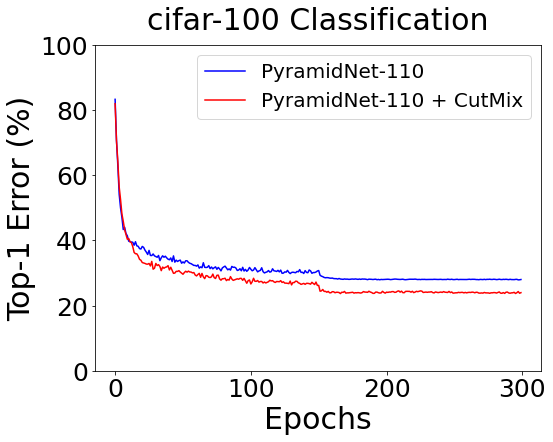

In [10]:
import matplotlib.pyplot as plt

def plot_(independent,dependent) :
    """
    """
        
    fig = plt.figure(1, figsize=(8,6))

    ax1 = fig.add_subplot()
    ax2 = fig.add_subplot()

    args_plot1 = [range(len(independent)), independent]
    args_plot2 = [range(len(dependent)), dependent]

    config_plot1 = dict(
        color='blue',
        linestyle='solid',
    )
    config_plot2 = dict(
        color='red',
        linestyle='solid',
    )

    ax1.plot(label='PyramidNet-110', *args_plot1, **config_plot1) ###<--- change label of plot graph
    ax2.plot(label='PyramidNet-110 + CutMix', *args_plot2, **config_plot2) ###<--- change label of plot graph
    
    plt.legend(loc='upper right', fontsize=20, shadow=False) ## 범례 생성 - 그림자 효과 추가
    
    plt.ylabel('Top-1 Error (%)',rotation=90, fontsize=30) ###<--- change y-label of plot graph
    plt.xlabel('Epochs',fontsize=30) ## x축 라벨

    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25) ## y축 눈금 크기 설정
    
    ax1.set_xticks([0,100,200,300])
    ax2.set_xticks([0,100,200,300])

    ax1.set_yticks([0,20,40,60,80,100])
    ax2.set_yticks([0,20,40,60,80,100])

    plt.title(f"cifar-100 Classification",fontsize=30, pad=15) ##<- change title of plot graph

    plt.show()



DIR = '/content/gdrive/MyDrive/DeepLearning'
methods=['mixup','cutout','cutmix','baseline']
checkpoints=[]
for method in methods :
  full_path=f"{DIR}/cifar100_pyramid110_{method}.pt"
  checkpoints.append(torch.load(full_path, map_location=torch.device('cpu')))

plot_(checkpoints[3]['top1_err'], checkpoints[2]['top1_err'])


#which method 
# 0: nothing, 
# 1: cutmix, 
# 2: mixup 
# 3: cutout

### You can see every code we've done at [Here](https://github.com/GwiHwan-Go/Reproduce_CutMix)